# Mini Project Part A - MODEL ANSWER

This is a template for Part A of your project. You are provided with the code to load the data.

For each task you need to write code in the 'Code' cell and answer the question in the 'Markdown' cell. There is a word limit to discourage lengthy commentaries. Be brief and clear.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

(433, 90, 90)


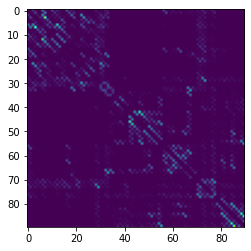

In [2]:
# load connectivity matrices
import pickle
matrices = pickle.load( open( "data/matrices.p", "rb" ) )
print(matrices.shape)
plt.imshow(matrices[1,:,:])

In [3]:
# convert upper triangles of the matrices to feature vectors

# dimensions
n = matrices.shape[0]
m = matrices.shape[1]
D = round(m*(m-1)/2)
print('n={}, D={}'.format(n,D))

# feature matrix
X=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X[i,index]=matrices[i,j,k]
            index=index+1
print(X.shape)

n=433, D=4005
(433, 4005)


In [4]:
# load subject info
subject_info = pd.read_csv('data/subject_info.csv')
subject_info

,age,prematurity
0,41,0
1,41,0
2,40,0
3,41,0
4,41,0
...,...,...
428,44,0
429,41,0
430,44,0
431,42,0


In [5]:
# load gray matter region descriptions - you will need this in Part B
# don't worry about the labels for now - there are here only to help you understand the dataset
label_names = pd.read_csv('data/label_names.csv')
label_names

,Label,Region name,Region description
0,1.0,Precentral_L,Precental gyrus
1,2.0,Precentral_R,Precental gyrus
2,3.0,Frontal_Sup_L,"Superior frontal gyrus, dorsolateral"
3,4.0,Frontal_Sup_R,"Superior frontal gyrus, dorsolateral"
4,5.0,Frontal_Sup_Orb_L,"Superior frontal gyrus, orbital part"
...,...,...,...
85,86.0,Temporal_Mid_R,Middle temporal gyrus
86,87.0,Temporal_Pole_Mid_L,Temporal pole: middle temporal gyrus
87,88.0,Temporal_Pole_Mid_R,Temporal pole: middle temporal gyrus
88,89.0,Temporal_Inf_L,Inferior temporal gyrus


## Preprocessing

**7 marks**

Include code that prepares your data for training machine learning models

In [6]:
# Your preprocessing

# Feature matrix
from sklearn.preprocessing import StandardScaler

# Use matrix X and scale the features
X = StandardScaler().fit_transform(X)

# Extract label vector
y = subject_info.to_numpy()[:,1]

**Describe what you have done and why [max 50 words]:**
* 2 We need to scale features `X`, so that we can effectlively fit and regularise the classifier 
* 1 We extract the label vector `y`

**FEEDBACK: Make sure you use standard scaler**


## Analysis of the dataset
**18 marks**

Print out important characeristics of the dataset to understand the problem. Visualise the dataset. (*Hint:* You can use PCA for visualisation)

Number of samples:  433
Number of features:  4005
Label vector (all samples):  433
Label vector (term):  346
Label vector (preterm):  87
Proportion of preterms: 0.2


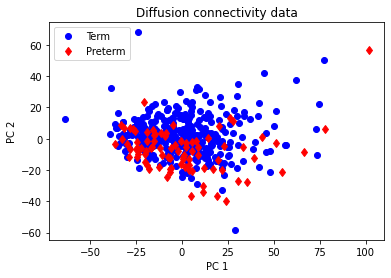

In [7]:
# your analysis

# Check how many samples and features we have
print('Number of samples: ',X.shape[0])
print('Number of features: ',X.shape[1])

# Check how many samples of each class we have
print('Label vector (all samples): ', y.shape[0])
print('Label vector (term): ', y[y==0].shape[0])
print('Label vector (preterm): ', y[y==1].shape[0])
print('Proportion of preterms:', np.round(y[y==1].shape[0]/y.shape[0],2))

# Visualise the dataset using PCA
from sklearn.decomposition import PCA
transf = PCA(n_components=2)
X_reduced = transf.fit_transform(X)

# Plot the data
def plotData(X,y):
    plt.plot(X[y==0,0],X[y==0,1],'bo', label = 'Term')
    plt.plot(X[y==1,0],X[y==1,1],'rd', label = 'Preterm')
    plt.legend()
    plt.title('Diffusion connectivity data')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    
plotData(X_reduced,y)


**Describe the challenges of succesfully fitting a classifier to this dataset [max 100 words]:**
* We have large number of features compared to the number of samples, so classifier will be prone to **overfitting**
* We have **unbalanced dataset**, so the smaller class (preterm) will be likely more difficult to predict correctly
* The dataset does not seem **separable**, so we can expect difficulties with achieving high performance

**FEEDBACK: Most of you identified at least some of these challenges, well done! It is important later on to describe how you addressed them, not everyone has done that.**

## Evaluation framework

**15 marks**

Include code and functions to prepare the framework for evaluation of your machine learning models. Think of different sets of data and performance measures that you will need to analyse the performance of your classifier. Make sure you
* display the sets of data that you created
* write functions to evaluate performance on each of the set later on (*Hint: you will need one different functions for different sets of data*)

### Test set
**FEEDBACK: The important first step is to extract the test set that will never be used during training and hyperparameter tuning. Most of you have done that. However, many of you did not perform stratification. This is important to make sure that we have the same number of term and preterm babies in training set and test set.**

Text(0.5, 1.0, 'test set')

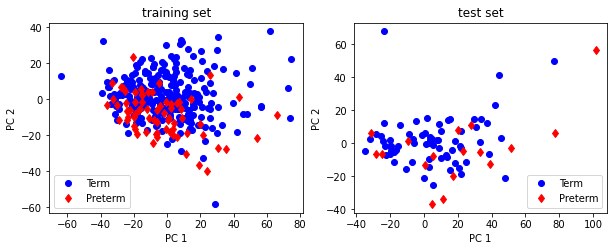

In [8]:
# different sets
from sklearn.model_selection import train_test_split

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y)

# plot training and test set
plt.figure(figsize=(10,3.5))
plt.subplot(121)
plotData(transf.transform(X_train),y_train)
plt.title('training set')
plt.subplot(122)
plotData(transf.transform(X_test),y_test)
plt.title('test set')

### Functions for evaluation

**FEEDBACK: For in-depth analysis we need to evaluate**
* **performance on the training set: compare direct fit and with cross-validation to spot overfitting**
* **performance on test set: never fit the model to the test set and do not use cross-validation either, as this peforms fitting!!!***

**We need to evaluate accuracy, sensitivity and specificity as a minimum, (see the theory in Week 4!)**

**We create two functions:**
* `evaluationCV` **which calculates cross-validated measures on training set (never on test set!!!)**
* `evaluation` **which calculates performance using a fitted model, but never fits the model again. This can be used on both training set and test set.**

**IMPORTANT: Many of you used cross-validation on the test set. This is wrong because we should never fit the model on the test set.**

In [9]:
# functions for evaluation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score

# Performance measures for cross-validation:
# accuracy for overall performance
# sensitivity and specificity due to class imbalance
# mean recall is a good summary measure (optional)


def evaluationCV(model,X,y):

    # accuracy
    scores = cross_val_score(model,X,y)
    print('CV accuracy:',round(scores.mean(),2))

    # predict using cross-validation
    y_pred = cross_val_predict(model,X,y)

    # default is sensitivity: pos_label = 1
    sensitivity = recall_score(y,y_pred)
    print('CV sensitivity: ',round(sensitivity,2))
    # pos_label = 0 gives specificity
    specificity = recall_score(y,y_pred,pos_label = 0)
    print('CV specificity: ',round(specificity,2))
    # average value
    mean_recall = recall_score(y,y_pred,average='macro')
    print('CV mean recall: ',round(mean_recall,2))
    
# Performance measures for training and test set
# accuracy for overall performance
# sensitivity and specificity due to class imbalance
# mean recall is a good summary measure (optional)

def evaluation(model,X,y):

    # accuracy
    print('accuracy: ', round(model.score(X,y),2))

    # predict (but do not fit!)
    y_pred = model.predict(X)

    # default is sensitivity: pos_label = 1
    sensitivity = recall_score(y,y_pred)
    print('sensitivity: ',round(sensitivity,2))
    # pos_label = 0 gives specificity
    specificity = recall_score(y,y_pred,pos_label = 0)
    print('specificity: ',round(specificity,2))
    # average value
    mean_recall = recall_score(y,y_pred,average='macro')
    print('mean recall: ',round(mean_recall,2))


**Explain the main features of your framework:**
* Stratified train-test split 
* accuracy, sensitivity and specificity to check performance for both classes due to class imbalance
* Training set: compare training and CV measures to spot overfitting
* Test set: evaluate performance of the classifier on an independent set

## Methods

**30 marks**

Train and tune your classifier. Use machine learning models that you learned in weeks 2-4. Make sure you print out the tuned parameters.

In [10]:
# Train Logistic regression classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(class_weight='balanced')
param_grid = {"C": np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(model, cv=5, param_grid=param_grid, scoring = 'recall_macro') 
_=grid_search.fit(X_train,y_train) 

print('Best C  :', grid_search.best_estimator_.C) 
print('Best mean recall:', round(grid_search.best_score_,2))

# best model
tuned_model = grid_search.best_estimator_

Best C  : 0.01
Best mean recall: 0.84


**Describe the main features of your classifier and how they address the challenges you identified above: [maximum 100 words]**
* Large number of features: We tuned regularisation parameter `C` to address the problem of over fitting. 
* Data imbalance: We used `class_weight = balanced` to give higher weights to the samples from the smaller class. Additionally we choose to maximise mean recall to force the classifier to find optimal ballance between sensitivity and specificity. 

**FEEDBACK: In this section, all you were required to do is to tune a classifier. You were not required to compare many classification approaches. Regularisation was sufficient to prevent overfitting, and some of you also used PCA, which is fine. Some of you however did not tune the number of PCA components, but selected only 2 or 3, and this resulted in a useless classifier with close to zero sensitivity. If using PCA it is essential to correctly select or tune the number of components.**

**We expected some consideration of class imbalance. Setting `class_weight` to `'balanced'` is a good option. Some of you tuned the classifier to maximise recall (sensitivity) which is a good idea given that sensitivity tends to be low for this dataset. I opted for mean recall, because it gives better balance between sensitivity and specificity. However, these measures do not always improve the sensitivity, depending on the random train test split.**

**Note: Some of you used SMOTE or RandomOverSampling to make number of samples in both classes the same to deal with class imbalance. While this is a good idea, you need to be careful to only a oversample the training set. This is more tricky to implement when using cross-validation, because if you first oversample and then split to folds, you get same/similar samples in training and validation, which artificially increases the CV performance and compromises hyper-parameter tuning. The true performance could be seen on test set.**

## Results
**30 marks**

Evaluate performance of your classifier.

### Performance on training set
It is good to check training performance to 
* see whether the model is not underfitted 
* compare to CV performance on training set to spot overfitting

In [11]:
print('Training performance:')
evaluation(tuned_model,X_train,y_train)

Training performance:
accuracy:  1.0
sensitivity:  1.0
specificity:  1.0
mean recall:  1.0


### Performance on training set using cross-validation
It is good to check CV performance on training set to
* compare to the training performance to check for overfitting
* for more robust overall performance because we are not sure whether the test set is truly representative of the dataset.

In [12]:
print('Training performance CV:')
evaluationCV(tuned_model,X_train,y_train)

Training performance CV:
CV accuracy: 0.92
CV sensitivity:  0.71
CV specificity:  0.97
CV mean recall:  0.84


### Performance on test set

Test performance is the only truly independent performance measure for which we are sure that no overfitting could have happen. Model must not be fitted to the test set and CV must not be used on test set.

However, the test set may not be truly representative of the whole dataset, so the test performance should be reviewed in conjunction with CV performance on training set.

In [13]:
print('Test performance:')
evaluation(tuned_model,X_test,y_test)

Test performance:
accuracy:  0.92
sensitivity:  0.59
specificity:  1.0
mean recall:  0.79


**Analyse the performance of the classifier:**
* Good accuracy and specificity, but sensitivity is low. This means that it can be difficult to identify preterm babies
* Performance on test set is similar to CV performance, though sligltly lower. This is likely because test set is not necessarily representative of the dataset, that's why the results may be different
* Training performance is much higher than using cross-validation, which means that classifier is still overfitted to the training set.

**FEEDBACK: Correct calculation of performance measures and their analysis was the weakest park of the coursework on average. Many of you have not done this correctly, or completely. Please pay attention to this part of model answer in particular.**

**Visualise the results using PCA.** For example, you can plot the data with their true labels in one plot and the predicted labels in the other.

Text(0.5, 1.0, 'test set: predicted labels')

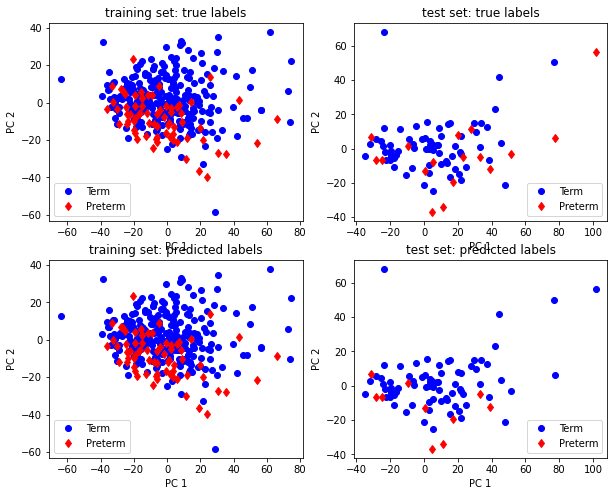

In [15]:
# plot 
plt.figure(figsize=(10,8))
plt.subplot(221)
plotData(transf.transform(X_train),y_train)
plt.title('training set: true labels')
plt.subplot(222)
plotData(transf.transform(X_test),y_test)
plt.title('test set: true labels')
plt.subplot(223)
plotData(transf.transform(X_train),tuned_model.predict(X_train))
plt.title('training set: predicted labels')
plt.subplot(224)
plotData(transf.transform(X_test),tuned_model.predict(X_test))
plt.title('test set: predicted labels')
